# Natural language processing
IMBD classifier 

## Importing Module

In [1]:
import numpy as np

import tensorflow as tf

from matplotlib import pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## Problem
- Build and train a binary classifier for the IMDB review dataset. 
- The classifier should have a final layer with 1 neuron activated by sigmoid.
- Do not use lambda layers in your model.

- The dataset used in this problem is originally published in http://ai.stanford.edu/~amaas/data/sentiment/

- Desired accuracy and validation_accuracy > `83%`

### Preparing data

In [2]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGXELCN/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGXELCN/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteGXELCN/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

Split data into two part

In [4]:
train_data, test_data = imdb['train'], imdb['test']
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

#### Explore data

Check total data

In [5]:
print(f'Total train data : {len(train_data)}')
print(f'Total test data : {len(test_data)}')

Total train data : 25000
Total test data : 25000


Print 5 text and label from train data

In [6]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(5)))
print(f'5 Text: \n{train_examples_batch}')
print()
print(f'5 Label: \n{train_labels_batch}')

5 Text: 
[b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
 b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot deve

#### Append Text and Label into list

In [7]:
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []


for s, l in train_data:
  train_sentences.append(s.numpy().decode('utf8'))
  train_labels.append(l.numpy())

for s, l in test_data:
  test_sentences.append(s.numpy().decode('utf8'))
  test_labels.append(l.numpy())

In [8]:
print(f'Total text train: {len(train_sentences)}')
print(f'Total text test: {len(train_sentences)}')

print(f'First 5 labels: {test_labels[:5]}')
print(f'Label on this data: {set(train_labels)}')

Total text train: 25000
Total text test: 25000
First 5 labels: [1, 1, 0, 0, 1]
Label on this data: {0, 1}


### Preparing Model

Set Paramters

In [28]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = '<OOV>'
BATCH_SIZE = 128

#### Tokenizer

In [10]:
def fit_tokenizer(sentences, num_words, oov_token):
  """
  Instantiates the Tokenizer class on the training sentences
    
  Args:
      sentences (list of string): lower-cased sentences without stopwords to be used for training
      num_words (int) - number of words to keep when tokenizing
      oov_token (string) - symbol for the out-of-vocabulary token
    
  Returns:
      tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
  """
  # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

   # Fit the tokenizer to the training sentences
  tokenizer.fit_on_texts(sentences)
  
  return tokenizer

In [11]:
tokenizer = fit_tokenizer(train_sentences, vocab_size, oov_tok)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 88583 words

<OOV> token included in vocabulary


#### Convert text to Sequence and Add Padding

In [12]:
def seq_and_pad(sentences, tokenizer, maxlen, padding='pre', truncating='pre'):
  """
  Generates an array of token sequences and pads them to the same length
    
  Args:
      sentences (list of string): list of sentences to tokenize and pad
      tokenizer (object): Tokenizer instance containing the word-index dictionary
      padding (string): type of padding to use
      maxlen (int): maximum length of the token sequence
    
  Returns:
      padded_sequences (array of int): tokenized sentences padded to the same length
  """  
  # Convert sentences to sequences
  sequences = tokenizer.texts_to_sequences(sentences)
    
  # Pad the sequences using the correct padding and maxlen
  padded_sequences = pad_sequences(sequences, 
                                   maxlen=maxlen, 
                                   padding=padding,
                                   truncating=truncating)

  return padded_sequences

In [13]:
train_padded_seq = seq_and_pad(train_sentences, tokenizer, max_length, truncating=trunc_type)
test_padded_seq = seq_and_pad(test_sentences, tokenizer, max_length, truncating=trunc_type)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {test_padded_seq.shape}")

Padded training sequences have shape: (25000, 120)

Padded validation sequences have shape: (25000, 120)


Convert labels to array

In [14]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

#### Build Model

In [29]:
def build_model(num_words, embedding_dim, maxlen):
  """
  Creates a text classifier model
    
  Args:
      num_words (int): size of the vocabulary for the Embedding layer input
      embedding_dim (int): dimensionality of the Embedding layer output
      maxlen (int): length of the input sequences
    
  Returns:
      model (tf.keras Model): the text classifier model
  """

  # Define Params  
  lr = 1e-3
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.BinaryCrossentropy()
  filters = 128
  kernel_size = 5

  # Define Activation Function
  relu = tf.nn.relu
  sigmoid = tf.nn.sigmoid

  # Define model sequential
  model = tf.keras.Sequential()

  # Define layer for Embedding text
  model.add(tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen))
  
  # Define Convolutional 1D layers
  model.add(tf.keras.layers.Conv1D(filters, kernel_size, activation=relu))

  # Flatten layers and add Dropout
  model.add(tf.keras.layers.GlobalAveragePooling1D())
  model.add(tf.keras.layers.Dropout(0.4))

  # Define fully connected layers
  model.add(tf.keras.layers.Dense(6, activation=relu))
  model.add(tf.keras.layers.Dense(1, activation=sigmoid))

  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['accuracy'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

#### Define Callbacks

In [32]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=8, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

### Train Model

In [34]:
model = build_model(vocab_size, embedding_dim, max_length)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 6)                 774       
                                                                 
 dense_9 (Dense)             (None, 1)                 7         
                                                      

In [35]:
history = model.fit(train_padded_seq, train_labels, 
                    epochs=50,
                    steps_per_epoch=50,
                    batch_size=BATCH_SIZE,
                    validation_data=(test_padded_seq, test_labels),
                    validation_steps=30,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/50
47/50 [===========================>..] - ETA: 0s - loss: 0.6911 - accuracy: 0.5740
Epoch 1: val_accuracy did not improve from 0.84219
50/50 [==============================] - 1s 12ms/step - loss: 0.6905 - accuracy: 0.5775 - val_loss: 0.6793 - val_accuracy: 0.6427
Epoch 2/50
41/50 [=======================>......] - ETA: 0s - loss: 0.6326 - accuracy: 0.7115
Epoch 2: val_accuracy did not improve from 0.84219
50/50 [==============================] - 0s 7ms/step - loss: 0.6189 - accuracy: 0.7203 - val_loss: 0.5297 - val_accuracy: 0.7776
Epoch 3/50
43/50 [========================>.....] - ETA: 0s - loss: 0.4720 - accuracy: 0.7972
Epoch 3: val_accuracy did not improve from 0.84219
50/50 [==============================] - 0s 7ms/step - loss: 0.4657 - accuracy: 0.7984 - val_loss: 0.4218 - val_accuracy: 0.8120
Epoch 4/50
49/50 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8192
Epoch 4: val_accuracy did not improve from 0.84219
50/50 [=========================

### Visualization result

In [36]:
def visualize_result(history):
  '''Function for Visual result'''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

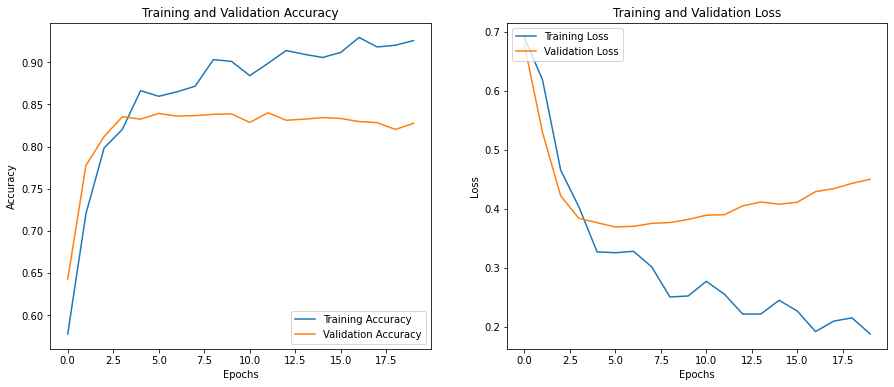

In [37]:
visualize_result(history)

### Download Model

In [ ]:
from google.colab import files
files.download(model.h5)